<a href="https://colab.research.google.com/github/IvanDaniarAP/MLTask/blob/main/week9/NN_on_Anydataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

# settings
LEARNING_RATE = 1e-4
# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 2500

DROPOUT = 0.5
BATCH_SIZE = 50

# set to 0 to train on all available data
VALIDATION_SIZE = 2000

# image number to output
IMAGE_TO_DISPLAY = 10

In [11]:
# read training data from CSV file
data = pd.read_csv('/content/train.csv')

print('data({0[0]},{0[1]})'.format(data.shape))
print (data.head())

data(891,12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN 

In [12]:
import numpy as np
import pandas as pd

# Assuming you want to exclude the first column (index 0) which may contain non-numeric values
numeric_data = data.iloc[:, 1:].copy()

# Convert each column to numeric, handling errors by coercing non-numeric values to NaN
for column in numeric_data.columns:
    numeric_data[column] = pd.to_numeric(numeric_data[column], errors='coerce')

# Fill NaN values with a specific value or use other imputation strategies if needed
numeric_data = numeric_data.fillna(0)  # Replace NaN with 0, adjust as needed

# Convert numeric data from [0:255] => [0.0:1.0]
numeric_data = numeric_data.astype(np.float) / 255.0

print('numeric_data({0},{1})'.format(numeric_data.shape[0], numeric_data.shape[1]))


numeric_data(891,11)


<ipython-input-12-f21f08eb551f>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numeric_data = numeric_data.astype(np.float) / 255.0


In [13]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 11
image_width => 4
image_height => 4


Image shape before reshaping: (11,)


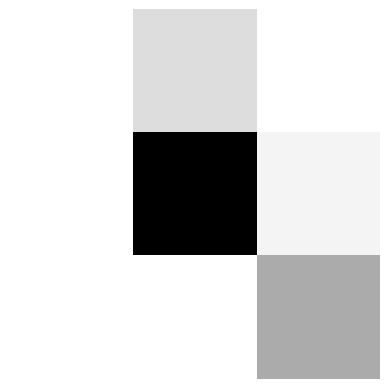

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Assuming image_width and image_height are defined somewhere in your code
image_width = 28
image_height = 28

# Assuming IMAGE_TO_DISPLAY is defined somewhere in your code
IMAGE_TO_DISPLAY = 0  # Change this to the index of the image you want to display

# display image
def display(img):
    # Handle non-numeric values by converting them to NaN
    img = pd.to_numeric(img, errors='coerce')
    img = np.asarray(img).astype(float)

    print("Image shape before reshaping:", img.shape)  # Add this line
    # Assuming img is a 1D array with size equal to 11
    # Reshape to a square (if possible) or handle based on your data
    square_size = int(np.sqrt(img.size))
    one_image = img[:square_size * square_size].reshape(square_size, square_size)

    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    plt.show()

# output image
display(images[IMAGE_TO_DISPLAY])


In [24]:
import pandas as pd

# Assuming data is your DataFrame, and IMAGE_TO_DISPLAY is defined somewhere in your code
IMAGE_TO_DISPLAY = 0  # Change this to the index of the image you want to display

# Extract labels
labels_flat = data.iloc[:, 0].values.ravel()

print('labels_flat({0})'.format(len(labels_flat)))
print('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY, labels_flat[IMAGE_TO_DISPLAY]))


labels_flat(891)
labels_flat[0] => 1


In [25]:
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 891


In [28]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))

    print("num_labels:", num_labels)
    print("index_offset shape:", index_offset.shape)
    print("labels_one_hot shape:", labels_one_hot.shape)

    try:
        labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    except IndexError as e:
        print("IndexError:", e)

    return labels_one_hot

# Assuming labels_flat and labels_count are defined somewhere in your code
labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels shape:', labels.shape)


num_labels: 891
index_offset shape: (891,)
labels_one_hot shape: (891, 891)
IndexError: index 793881 is out of bounds for size 793881
labels shape: (891, 891)


In [29]:
# split data into training & validation
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]


print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(0,11)
validation_images(891,11)


In [30]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [31]:
# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [32]:
# pooling
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [35]:
import tensorflow as tf

# Weight initialization using tf.keras.initializers
def weight_variable(shape):
    initial = tf.keras.initializers.TruncatedNormal(stddev=0.1)(shape)
    return tf.Variable(initial)


In [45]:
import tensorflow as tf

# Define your image input placeholder using tf.keras.Input
x = tf.keras.Input(shape=(image_width, image_height, 1), dtype=tf.float32)

# ... (other parts of your code)

# First convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

image = tf.reshape(x, [-1, image_width, image_height, 1])
h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# ... (the rest of your code)


In [46]:
# densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (40000, 1024)

In [51]:
# ... (other parts of your code)

# Fully connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
h_fc1_drop = tf.nn.dropout(h_fc1, rate=1 - keep_prob[0])

# ... (the rest of your code)


In [52]:
# ... (previous parts of your code)

# Readout layer
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# ... (the rest of your code)


In [59]:
import tensorflow as tf

# Define a placeholder for the true labels using tf.keras.Input
y_ = tf.keras.Input(shape=(labels_count,), dtype=tf.float32)

# ... (other parts of your code)

# Cost function
cross_entropy = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

# Optimization function
optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

# Define a function to compute gradients and apply them
@tf.function
def train_step():
    gradients = tape.gradient(cross_entropy, optimizer.variables)
    optimizer.apply_gradients(zip(gradients, optimizer.variables))

# Evaluation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))


In [60]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

In [61]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):

    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed

    start = index_in_epoch
    index_in_epoch += batch_size

    # when all trainig data have been already used, it is reorder randomly
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [67]:
import tensorflow as tf

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Now you can use sessions and explicit variable initialization
init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)
    # Rest of your code with explicit session.run() calls


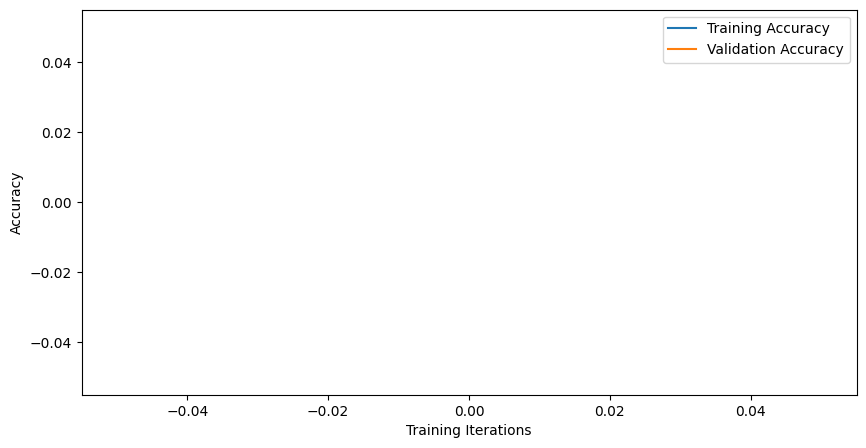

In [69]:
import matplotlib.pyplot as plt

# ... (your training loop)

# Visualize training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(x_range, train_accuracies, label='Training Accuracy')

if VALIDATION_SIZE:
    plt.plot(x_range, validation_accuracies, label='Validation Accuracy')

plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
